# 11.8 Lab: Survival Anlaysis




## 11.8.1 Brain Cancer

In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

In [2]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data

In [3]:
from lifelines import \
(KaplanMeierFitter,
CoxPHFitter)
from lifelines.statistics import \
(logrank_test,
multivariate_logrank_test)
from ISLP.survival import sim_time

In [4]:
BrainCancer = load_data('BrainCancer')
BrainCancer.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [5]:
BrainCancer['sex'].value_counts()

,count
sex,
Female,45
Male,43


In [6]:
BrainCancer['diagnosis'].value_counts()

,count
diagnosis,
Meningioma,42
HG glioma,22
Other,14
LG glioma,9


In [7]:
BrainCancer['status'].value_counts()

,count
status,
0,53
1,35


<Axes: title={'center': 'Kaplan Meier Estimates'}, xlabel='timeline'>

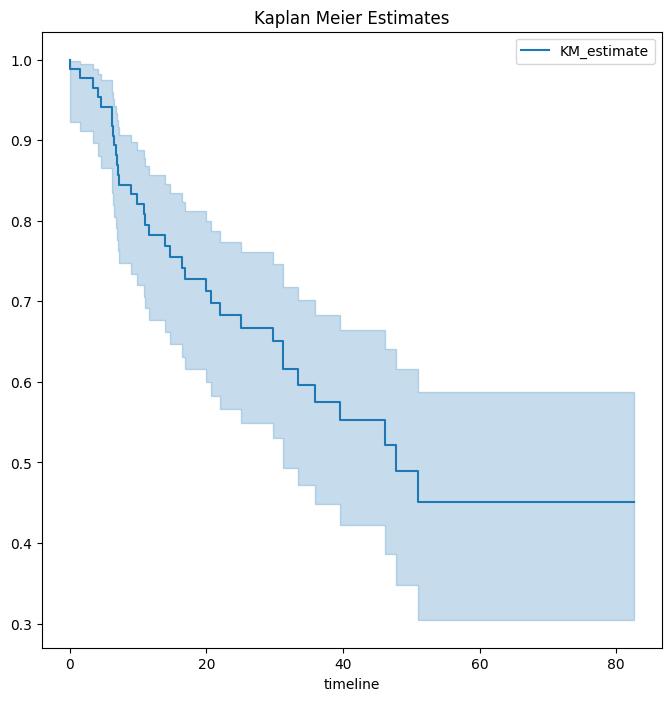

In [8]:
fig, ax = subplots(figsize = (8,8))
km = KaplanMeierFitter()
km_brain = km.fit(BrainCancer['time'], BrainCancer['status'])
km_brain.plot(ax = ax, title = 'Kaplan Meier Estimates')



<ipython-input-9-1a49c981efc0>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for sex, df in BrainCancer.groupby('sex'):


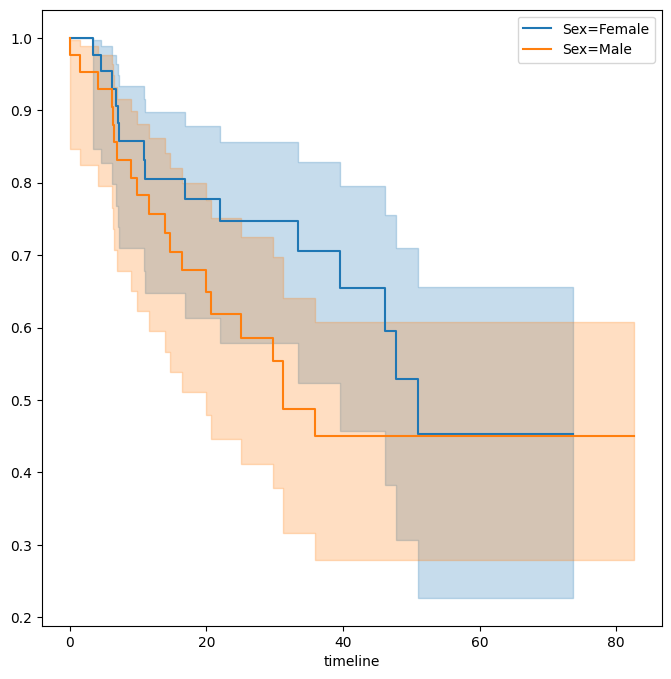

In [9]:
fig, ax = subplots(figsize=(8,8))
by_sex = {}
for sex, df in BrainCancer.groupby('sex'):
  by_sex[sex] = df
  km_sex = km.fit(df['time'], df['status'])
  km_sex.plot(label='Sex=%s' % sex, ax=ax)

In [10]:
logrank_test(by_sex['Male']['time'], by_sex['Female']['time'], by_sex['Male']['status'], by_sex['Female']['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

In [13]:
coxph = CoxPHFitter
sex_df = BrainCancer[['time', 'status', 'sex']]
model_df = MS(['time', 'status', 'sex'],
intercept=False).fit_transform(sex_df)
cox_fit = coxph().fit(model_df,'time','status')
cox_fit.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
sex[Male],0.407668,0.342004,0.233262


In [14]:
cox_fit.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

In [15]:
cleaned = BrainCancer.dropna()
all_MS = MS(cleaned.columns, intercept=False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph().fit(all_df,'time','status')
fit_all.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
sex[Male],0.183748,0.360358,0.610119
diagnosis[LG glioma],-1.239530,0.579555,0.032455
diagnosis[Meningioma],-2.154566,0.450524,0.000002
diagnosis[Other],-1.268870,0.617672,0.039949
loc[Supratentorial],0.441195,0.703669,0.530665
ki,-0.054955,0.018314,0.002693
gtv,0.034293,0.022333,0.124661
stereo[SRT],0.177778,0.601578,0.767597


In [16]:
levels = cleaned['diagnosis'].unique()
def representative(series):
  if hasattr(series.dtype, 'categories'):
    return pd.Series.mode(series)
  else:
    return series.mean()
modal_data = cleaned.apply(representative, axis=0)

In [17]:
modal_df = pd.DataFrame([modal_data.iloc[0] for _ in range(len(levels))])
modal_df['diagnosis'] = levels
modal_df

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,HG glioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,LG glioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,Other,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621


In [18]:
modal_X = all_MS.transform(modal_df)
modal_X.index = levels
modal_X

,sex[Male],diagnosis[LG glioma],diagnosis[Meningioma],diagnosis[Other],loc[Supratentorial],ki,gtv,stereo[SRT],status,time
Meningioma,0.0,0.0,1.0,0.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621
HG glioma,0.0,0.0,0.0,0.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621
LG glioma,0.0,1.0,0.0,0.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621
Other,0.0,0.0,0.0,1.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621


In [19]:
predicted_survival = fit_all.predict_survival_function(modal_X)
predicted_survival

,Meningioma,HG glioma,LG glioma,Other
0.07,0.997947,0.982430,0.994881,0.995029
1.18,0.997947,0.982430,0.994881,0.995029
1.41,0.995679,0.963342,0.989245,0.989555
1.54,0.995679,0.963342,0.989245,0.989555
2.03,0.995679,0.963342,0.989245,0.989555
...,...,...,...,...
65.02,0.688772,0.040136,0.394181,0.404936
67.38,0.688772,0.040136,0.394181,0.404936
73.74,0.688772,0.040136,0.394181,0.404936
78.75,0.688772,0.040136,0.394181,0.404936


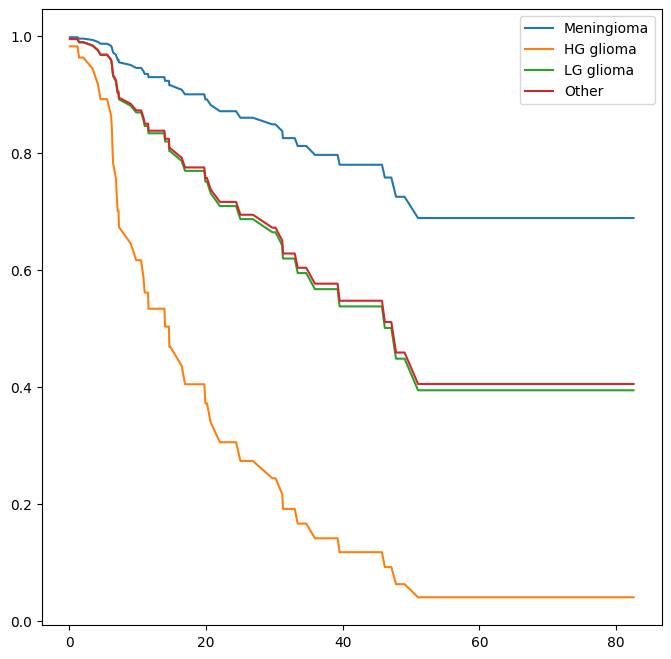

In [20]:
fig, ax = subplots(figsize=(8, 8))
predicted_survival.plot(ax=ax);

## 11.8.2 Publiciation Data

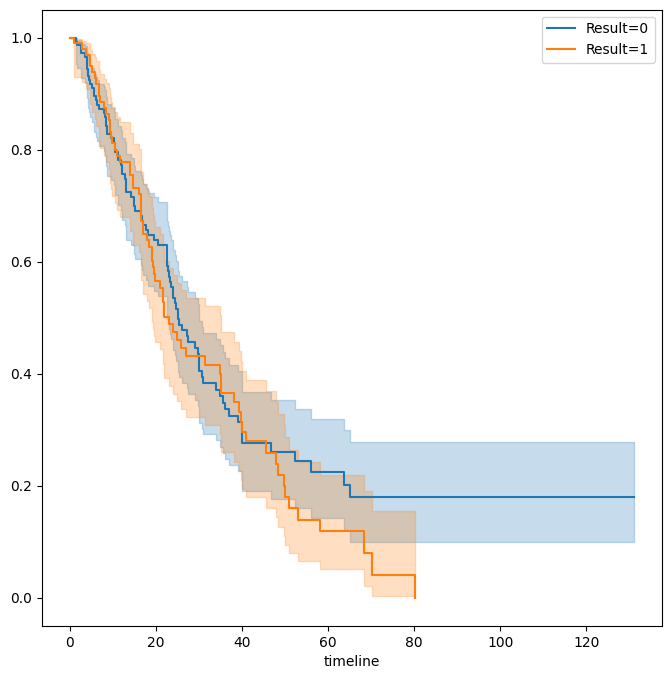

In [21]:
fig, ax = subplots(figsize=(8,8))
Publication = load_data('Publication')
by_result = {}
for result, df in Publication.groupby('posres'):
  by_result[result] = df
  km_result = km.fit(df['time'], df['status'])
  km_result.plot(label='Result=%d' % result, ax=ax)

In [22]:
posres_df = MS(['posres','time','status'],
intercept=False).fit_transform(Publication)
posres_fit = coxph().fit(posres_df,'time','status')
posres_fit.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
posres,0.148076,0.161625,0.359579


In [23]:
model = MS(Publication.columns.drop('mech'), intercept=False)
coxph().fit(model.fit_transform(Publication), 'time','status').summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
posres,0.570773,0.175960,1.179610e-03
multi,-0.040860,0.251194,8.707842e-01
clinend,0.546183,0.262000,3.709944e-02
sampsize,0.000005,0.000015,7.507005e-01
budget,0.004386,0.002465,7.515984e-02
impact,0.058318,0.006676,2.426306e-18


In [24]:
# P value drastically changes with the addition of other variables

## 11.8.3 Call Center Data

In [25]:
rng = np.random.default_rng(10)
N = 2000
Operators = rng.choice(np.arange(5, 16), N, replace=True)
Center = rng.choice(['A', 'B', 'C'],N, replace=True)
Time = rng.choice(['Morn.', 'After.', 'Even.'],N,replace=True)
D = pd.DataFrame({'Operators': Operators,'Center': pd.Categorical(Center),'Time': pd.Categorical(Time)})

In [26]:
model = MS(['Operators', 'Center', 'Time'], intercept=False)
X = model.fit_transform(D)